In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.dates

from sklearn.utils import shuffle
import copy

%matplotlib inline

# Adatok
Az adathalmaz kicsi, 741 adatot tartalmaz. Az http://idojarasbudapest.hu/archivalt-idojaras oldalról lett kinyerve. Minden év napi minimum és maximum értéke szerepel 2011-től kezdve, viszont csak a Szeptember-December közti időszak lett elmentve. Célom a megadott időpontokban(október, november) a lehető legjobb becslés megadása, így eldobtam azokat az adatokat amik nem a cél körülötti időszakot ölelik fel. Így kevesebb adatom lett, viszont a feladat is kicsit könnyebbé vált a háló számára.

In [2]:
df = pd.read_csv("weather_data.csv")
df.head()

,year,month,day,max,min
0,2015,11,1,16.0,3.0
1,2015,11,2,13.0,3.0
2,2015,11,3,13.0,4.0
3,2015,11,4,13.0,3.0
4,2015,11,5,15.0,7.0


In [3]:
df.shape

(741, 5)

In [4]:
df.year = df.year.astype(str)
df.month = df.month.astype(str)
df.day = df.day.astype(str)
df["date"] = df[["year", "month", "day"]].apply(lambda x: ''.join(x), axis=1)

df["date"] = pd.to_datetime(df["date"], format='%Y%m%d')

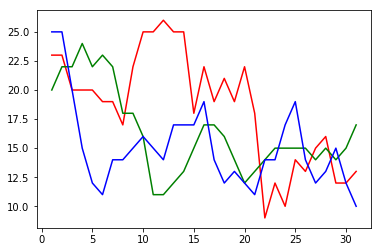

In [5]:
mask0 = (df["date"] >= '2014-10-01') & (df["date"] <= '2014-10-31')
mask1 = (df["date"] >= '2015-10-01') & (df["date"] <= '2015-10-31')
mask2 = (df["date"] >= '2016-10-01') & (df["date"] <= '2016-10-31')
selected1 = df.loc[mask0]
selected2 = df.loc[mask1]
selected3 = df.loc[mask2]
okt = np.arange(1,32,1)

plt.plot(okt, selected1["max"], "r", okt, selected2["max"], "g", okt, selected3["max"], "b")
plt.show()

Az ábra a 2014-2016 közti októberi hőmérsékleteket jeleníti meg. Látható hogy csak minimális a korreláció az adatok közt(az azért látható, hogy csökken tíz fokot a hőmérséklet).

# Háló
Elsősorban min-maxolom az adatokat. A legrégebbi adat 2011-es, viszont a maximumot 2018-ban határoztam mag, hogy nagyjából 1 szórású, de még a jövőben is kiértékelhető legyen. Úgyanígy hónapoknál szeptember a minimum december a maximum.

In [6]:
def min_max_datedata(date, reverse=False):
    if not reverse:
        y = (date[0] - 2011)/(2018-2011)
        m = (date[1] - 8)/(12-8)
        d = (date[2] - 1)/(31-1)
    else:
        y = date[0]*(2018-2011) + 2011
        m = date[1]*(12 - 8) + 8
        d = date[2]*(31 - 1) + 1
    return np.array([y,m,d]).astype('float')

def min_max_tempdata(temps, reverse=False):
    if not reverse:
        max = (temps[0] + 20)/(50 + 20)
        min = (temps[1] + 20)/(50 + 20)
    else:
        max = temps[0]*(50+20) - 20
        min = temps[1]*(50 + 20) - 20
    return np.array([max, min]).astype('float')

A háló a bemeneten megkapja a dátum három értékét és ez alapján megbecsüli a dátumhoz kapcsolódó minimum és maximum hőméréskletértéket.

In [7]:
class WeatherDataset(Dataset):

    def __init__(self, data_frame): 
        self.data_tensor = data_frame[['year','month','day']].as_matrix()
        self.target_tensor = data_frame[['max','min']].as_matrix()

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, item):
        return min_max_datedata(self.data_tensor[item]), min_max_tempdata(self.target_tensor[item])


class WeatherNet(torch.nn.Module):
    
    def __init__(self, D_in, D_out):
        super(WeatherNet, self).__init__()

        self.layer1 = torch.nn.Linear(D_in, 30)
        self.layer2 = torch.nn.Linear(30, 6)
        self.layer3 = torch.nn.Linear(6, D_out)

    def forward(self, X):
        y_ = F.relu(self.layer1(X))
        y_ = F.relu(self.layer2(y_))
        y_ = F.relu(self.layer3(y_))

        return y_

A kevés mintaadat miatt kereszt-validációt alkalmaztam 10:1 arányban és a tesztadatokat sem a .csv fájlban található adatokból különítettem el, hanem az adatgyűjtés és notebook írása között keletkező adatok vannak erre felhasználva.

In [8]:
def df_to_multiple_dfs(df):
    dfs = []
    size = df.shape[0]
    prev_i = 0
    for i in range(int(size/10), size, int(size/10)):
        dfs.append(df.iloc[prev_i:i])
        prev_i = i
    
    return dfs

def train():
    # Network dimensions
    D_in, D_out, batch = 3, 2, 16
    dtype = torch.FloatTensor
    
    # Reading and shuffle data
    df = pd.read_csv("weather_data.csv")
    df = shuffle(df)
    
    # Split the shufled data
    dfs = df_to_multiple_dfs(df)
    
    # Build the network
    net = WeatherNet(D_in, D_out)

    # Define the loss and the optimizer
    criteria = torch.nn.MSELoss()
    optimizer = Adam(net.parameters())

    # Variables for early stopping
    best_model = copy.deepcopy(net)
    patience = 0
    prev_valid_loss = float("inf")
    
    for epoch in range(100):
        running_loss = 0.0
      
        # Cross validation cycle
        for k in range(10):
            # One part of the data is the validation set, the rest is the train set
            df_valid = dfs[k]
            df_train = pd.concat(dfs[:k] + dfs[k+1:])
            
            # Push data to Pytorch dataset
            ds_valid = WeatherDataset(df_valid)
            ds_train = WeatherDataset(df_train)
            
            # Push data to a Pytorch DataLoader
            dl_valid = DataLoader(ds_valid, batch_size=batch, shuffle=False, pin_memory=False, drop_last=True)
            dl_train = DataLoader(ds_train, batch_size=batch, shuffle=False, pin_memory=False, drop_last=True)

            # Train cycle
            for i, data in enumerate(dl_train,0):
                # Convert data to torch variable
                X, y = data
                X, y = Variable(X.type(dtype)), Variable(y.type(dtype))
                
                # clearing gradients
                optimizer.zero_grad()

                # Making the prediction and propagating the loss back
                y_ = net(X)
                loss = criteria(y_, y)
                loss.backward()
                optimizer.step()

                running_loss += loss.data[0]
                if i % 20 == 19:
                    print('Epoch %d, Train iteration: %5d,  loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    running_loss = 0.0
                    
            valid_loss = 0.0
            n = 0
            # Validation cycle
            for i, data in enumerate(dl_valid,0):
                n+=1
                # Convert data to torch variable
                X, y = data    
                X, y = Variable(X.type(dtype)), Variable(y.type(dtype))
                
                # Making the prediction and compute the loss
                y_ = net(X)
                loss = criteria(y_, y)

                valid_loss += loss.data[0]
            valid_loss = valid_loss/n
            print('Epoch: %d, Cross valid cycle: %5d, valid_loss: %.3f' % (epoch + 1, k + 1, valid_loss))
            
            # Early stopping
            if prev_valid_loss < valid_loss:
                patience += 1
            else:
                prev_valid_loss = valid_loss
                patience = 0
                best_model = copy.deepcopy(net)
            
            if patience > 10:
                print("Early stopping...")
                net = best_model
                break
        
        if patience > 10:
            break
            

    print('Training finished')
    return net

In [9]:
net = train()

Epoch 1, Train iteration:    20,  loss: 0.083
Epoch 1, Train iteration:    40,  loss: 0.078
Epoch: 1, Cross valid cycle:     1, valid_loss: 0.083
Epoch 1, Train iteration:    20,  loss: 0.084
Epoch 1, Train iteration:    40,  loss: 0.076
Epoch: 1, Cross valid cycle:     2, valid_loss: 0.082
Epoch 1, Train iteration:    20,  loss: 0.082
Epoch 1, Train iteration:    40,  loss: 0.074
Epoch: 1, Cross valid cycle:     3, valid_loss: 0.082
Epoch 1, Train iteration:    20,  loss: 0.082
Epoch 1, Train iteration:    40,  loss: 0.074
Epoch: 1, Cross valid cycle:     4, valid_loss: 0.076
Epoch 1, Train iteration:    20,  loss: 0.081
Epoch 1, Train iteration:    40,  loss: 0.074
Epoch: 1, Cross valid cycle:     5, valid_loss: 0.079
Epoch 1, Train iteration:    20,  loss: 0.082
Epoch 1, Train iteration:    40,  loss: 0.074
Epoch: 1, Cross valid cycle:     6, valid_loss: 0.073
Epoch 1, Train iteration:    20,  loss: 0.082
Epoch 1, Train iteration:    40,  loss: 0.074
Epoch: 1, Cross valid cycle:    

Epoch 7, Train iteration:    40,  loss: 0.073
Epoch: 7, Cross valid cycle:     2, valid_loss: 0.079
Epoch 7, Train iteration:    20,  loss: 0.080
Epoch 7, Train iteration:    40,  loss: 0.073
Epoch: 7, Cross valid cycle:     3, valid_loss: 0.081
Epoch 7, Train iteration:    20,  loss: 0.082
Epoch 7, Train iteration:    40,  loss: 0.073
Epoch: 7, Cross valid cycle:     4, valid_loss: 0.076
Epoch 7, Train iteration:    20,  loss: 0.081
Epoch 7, Train iteration:    40,  loss: 0.073
Epoch: 7, Cross valid cycle:     5, valid_loss: 0.079
Epoch 7, Train iteration:    20,  loss: 0.081
Epoch 7, Train iteration:    40,  loss: 0.074
Epoch: 7, Cross valid cycle:     6, valid_loss: 0.073
Epoch 7, Train iteration:    20,  loss: 0.081
Epoch 7, Train iteration:    40,  loss: 0.074
Epoch: 7, Cross valid cycle:     7, valid_loss: 0.072
Epoch 7, Train iteration:    20,  loss: 0.081
Epoch 7, Train iteration:    40,  loss: 0.073
Epoch: 7, Cross valid cycle:     8, valid_loss: 0.077
Epoch 7, Train iteration

Az adatok október 13-ig vannak összeszedve, a tesztadatok 14-től a Notebook írásának napjáig összeszedett adatok lesznek

In [10]:
dtype = torch.FloatTensor
predictions = []
test = [18.4, 20.5, 21, 21.4, 20.5, 18.8, 19.4, 16.9, 16.4, 10.6, 13.1]
days = len(test)
for i in range(days):
    pred = net(Variable(torch.from_numpy(min_max_datedata([2017,10,14 + i]))).type(dtype))
    predictions.append(min_max_tempdata(pred.data.numpy(),True)[0])

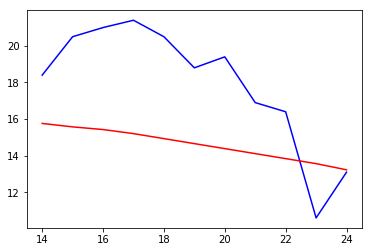

In [11]:
days = np.arange(14, 14+days)
plt.plot(days, test, "b", days, predictions, "r")
plt.show()

# Értékelés
A tesztadat grafikonon látni, hogy a neuronháló megtanulta "átlagolni" a hőmérsékletet. Nincsenek ugrások mint azt a valódi adatokon látható, hanem szépen követi, hogy mennyit csökken havonta a hőmérséklet. Ez nem is annyira meglepő, mert fentebb láthattuk a tanító adatok vizualizálásánál, hogy amiben hasonlítottak egymásra a grafikonok az kizárólag az volt, hogy ugrásokk mellett a hó végére csökkent a hőmérésklet.

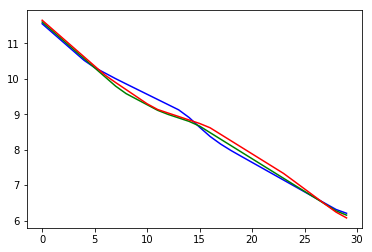

In [12]:
predictions1 = []
predictions2 = []
predictions3 = []

days = 30
for i in range(1, days+1):
    pred1 = net(Variable(torch.from_numpy(min_max_datedata([2017,11,i]))).type(dtype))
    pred2 = net(Variable(torch.from_numpy(min_max_datedata([2018,11,i]))).type(dtype))
    pred3 = net(Variable(torch.from_numpy(min_max_datedata([2019,11,i]))).type(dtype))
    
    predictions1.append(min_max_tempdata(pred1.data.numpy(),True)[0])
    predictions2.append(min_max_tempdata(pred2.data.numpy(),True)[0])
    predictions3.append(min_max_tempdata(pred3.data.numpy(),True)[0])
    
days = np.arange(0, days)
plt.plot(days, predictions1, "b", days, predictions2, 'g', days, predictions3, 'r')
plt.show()

Az háló is tagadja a globális felmelegedést :/

In [13]:
okthh = net(Variable(torch.from_numpy(min_max_datedata([2017,10,27]))).type(dtype))
novh = net(Variable(torch.from_numpy(min_max_datedata([2017,11,3]))).type(dtype))
novhn = net(Variable(torch.from_numpy(min_max_datedata([2017,11,24]))).type(dtype))

okthh = min_max_tempdata(okthh.data.numpy(),True)[0]
novh = min_max_tempdata(novh.data.numpy(),True)[0]
novhn = min_max_tempdata(novhn.data.numpy(),True)[0]

In [14]:
print("Oktober 27: %f" % (okthh))
print("November 3: %f" % (novh))
print("November 24: %f" % (novhn))

Oktober 27: 12.168781
November 3: 11.031572
November 24: 7.142982
